In [7]:
import pandas as pd 
import pyforest
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import *

from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

import pyforest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [9]:
df=pd.read_csv('Cleaned_data.csv',keep_default_na=False)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6.0,25.0,1.0,1.0,BC,Pediatrics-Endocrinology,41.0,...,No,No,No,No,No,No,No,No,No,0.0
1,Caucasian,Female,[10-20),1.0,1.0,7.0,3.0,OG,InternalMedicine,59.0,...,No,Up,No,No,No,No,No,Ch,Yes,0.0
2,AfricanAmerican,Female,[20-30),1.0,1.0,7.0,2.0,BC,InternalMedicine,11.0,...,No,No,No,No,No,No,No,No,Yes,0.0
3,Caucasian,Male,[30-40),1.0,1.0,7.0,2.0,HM,InternalMedicine,44.0,...,No,Up,No,No,No,No,No,Ch,Yes,0.0
4,Caucasian,Male,[40-50),1.0,1.0,7.0,1.0,BC,Emergency/Trauma,51.0,...,No,Steady,No,No,No,No,No,Ch,Yes,0.0


In [11]:
model_df=pd.read_csv('Model_data.csv')
model_df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2.0,0.0,0.0,6.0,25.0,1.0,1.0,0.0,37.0,41.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,0.0,1.0,1.0,1.0,7.0,3.0,10.0,18.0,59.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,2.0,1.0,1.0,7.0,2.0,0.0,18.0,11.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2.0,1.0,3.0,1.0,1.0,7.0,2.0,6.0,18.0,44.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,4.0,1.0,1.0,7.0,1.0,0.0,8.0,51.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 4. Feature Engineering

#### 4.1. Transformations required
##### Whether any transformations required
Data transformation is essential for preparing the dataset for model building. In our case, label encoding was applied to the dataset to make it suitable for the model. Additionally, the target variable ('readmitted') was created based on the following conditions:
* 0: If df['readmitted'] is '>30' or 'NO'
* 1: If df['readmitted'] is '<30'

### 4.2. Scaling the data

#### Scaling
Scaling continuous variables is crucial to ensure they have a meaningful impact on the model. However, scaling columns with binary values (0 or 1) is unnecessary as it doesn't improve the model's performance. Since binary variables, such as dummy variables, represent categorical information, scaling them would distort their intended influence. In our dataset, there are no continuous numerical variables, so there is no need for scaling. Without continuous variables, we don't have to worry about the issues that arise from scaling such features, and thus can focus on other preprocessing steps to prepare the data for model building.

### 4.3. Feature selection

#### Recursive Feature Elimination:
Recursive Feature Elimination (RFE) is a powerful feature selection technique in machine learning that helps identify the most relevant features for model training. By recursively removing the least important features, RFE aims to improve the model’s performance by reducing overfitting and enhancing interpretability. It is especially useful when working with datasets that contain many features, allowing you to narrow down the dataset to only the most significant ones.

#### Steps to Use RFE:

    1.Choose an Estimator:
    RFE requires an estimator (like DecisionTreeClassifier, LogisticRegression, etc.) that can calculate feature importance.

    2.Specify Number of Features:
    Define the number of features you want to keep using the n_features_to_select parameter.

    3.Fit the Model:
    Fit the RFE model to the training data using fit(). It evaluates the features and eliminates the least important ones.
    
    4.Evaluate Feature Selection:
    Use the support_ attribute to see which features are selected (True for selected). The ranking_ attribute shows the rank of all features (1 for most important).
    
    5.Transform the Data:
    Use transform() to apply the feature selection to the dataset, keeping only the most important features.

In [21]:
X = model_df.drop(columns=['readmitted'])  # Features
y = model_df['readmitted']  # Target variable

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [27]:
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution after SMOTE:
readmitted
0.0    72340
1.0    72340
Name: count, dtype: int64


In [54]:
model = DecisionTreeClassifier(random_state=42)

rfe = RFE(estimator=model, n_features_to_select=15)  

# Fit RFE to the training data
rfe.fit(X_train_smote, y_train_smote)

# Get the ranking of features
ranking = rfe.ranking_

# Create a DataFrame to display the feature names and their rankings
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': ranking})
feature_ranking=feature_ranking.sort_values(by='Ranking').reset_index()
feature_ranking.drop('index',axis=1,inplace=True)
print(feature_ranking)

# Evaluate the model with the selected features
X_train_selected = rfe.transform(X_train_smote)
X_test_selected = rfe.transform(X_test)

# Fit the model with the selected features
model.fit(X_train_selected, y_train_smote)
y_pred = model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with selected features: {accuracy:.4f}")


                     Feature  Ranking
0                  metformin        1
1                     change        1
2           number_diagnoses        1
3                     diag_3        1
4                     diag_2        1
5                     diag_1        1
6           number_inpatient        1
7            num_medications        1
8         num_lab_procedures        1
9                diabetesMed        1
10          time_in_hospital        1
11  discharge_disposition_id        1
12                       age        1
13                    gender        1
14         medical_specialty        1
15            num_procedures        2
16                payer_code        3
17          number_emergency        4
18                   insulin        5
19                 glipizide        6
20         admission_type_id        7
21         number_outpatient        8
22       admission_source_id        9
23                      race       10
24                 A1Cresult       11
25          

In [58]:
# Create a DataFrame to display the feature names and their rankings
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': ranking})

# Extract the top 15 features (Ranking = 1 indicates they are selected)
top_15_features = feature_ranking[feature_ranking['Ranking'] == 1]['Feature'].tolist()

# Print the top 15 features
print(f"Top 15 features selected by RFE: {top_15_features}")

Top 15 features selected by RFE: ['gender', 'age', 'discharge_disposition_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_medications', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'change', 'diabetesMed']


### 4.4. Dimensionality Reduction

# 5. Assumptions

# 6. Building and evaluation of Base model

#### With RFE

In [ ]:
"""
   Function Name: compare_models

   Description: This **function** compares various algorithms on 
                 1) AUROC 2) Precision, 3) Recall
   
   Input: 1) splits for k fold 
          2) random seed number
          3) Training data for predictor variables
          4) Training data for target variable



   Output: Model comparison on these metrics 1) AUROC 2) Metrics - Precision, Recall
   
"""

In [60]:
def compare_models(n_splits, random_state, X, Y):      
    import  matplotlib.pyplot            as      plt
    from    sklearn.model_selection      import  StratifiedKFold
    from    sklearn.model_selection      import  cross_val_score
    from    sklearn.linear_model         import  LogisticRegression
    from    sklearn.tree                 import  DecisionTreeClassifier
    from    sklearn.naive_bayes          import  GaussianNB
    from    sklearn.ensemble             import  RandomForestClassifier
    from    sklearn.neighbors            import  KNeighborsClassifier     
    from    xgboost                      import  XGBClassifier  
    
    ### Prepare models
    models  = []
    models.append(('LR', LogisticRegression(max_iter = 20000))) 
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))        

    ### Evaluate model in turn
    scores_req =  ['recall']
    print("\n n_splits %d random_state %d" % (n_splits, random_state))     
    for i in range(len(scores_req)):
        names          =   []
        results        =   []
        scoring        =   scores_req[i]
        print(scoring)
         
        for name, model in models:
            skf            =   StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
            cv_results     =   cross_val_score(model, X, Y, cv = skf, scoring = scoring)
            results.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)
        
        ### Box plot algorithm comparison
        sub_title = 'Algorithm Comparison using ' + scoring
        fig = plt.figure()
        fig.suptitle(sub_title)
        ax  = fig.add_subplot(111)
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.show()

In [64]:
X = model_df[['gender', 'age', 'discharge_disposition_id', 'time_in_hospital',
              'payer_code', 'medical_specialty', 'num_lab_procedures',
              'num_medications','number_inpatient', 'diag_1', 'diag_2',
              'diag_3', 'number_diagnoses', 'change', 'diabetesMed']
]  # Features
y = model_df['readmitted']  # Target variable

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [70]:
n_splits=10
random_state=12345


 n_splits 10 random_state 12345
recall
LR: 0.512123 (0.006918)
CART: 0.893724 (0.002596)
NB: 0.632264 (0.006592)
RF: 0.878007 (0.003209)
KNN: 0.979375 (0.002198)


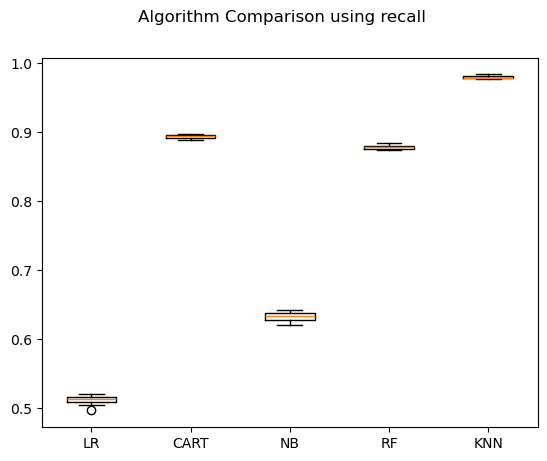

In [72]:
compare_models(n_splits, random_state, X_train_smote, y_train_smote)

#### With RFE and Without Smoting

In [80]:
X = model_df[['gender', 'age', 'discharge_disposition_id', 'time_in_hospital',
              'payer_code', 'medical_specialty', 'num_lab_procedures',
              'num_medications','number_inpatient', 'diag_1', 'diag_2',
              'diag_3', 'number_diagnoses', 'change', 'diabetesMed']
]  # Features
y = model_df['readmitted']  # Target variable

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 n_splits 10 random_state 12345
recall
LR: 0.014880 (0.003422)
CART: 0.186174 (0.016320)
NB: 0.129740 (0.010305)
RF: 0.009589 (0.002873)
KNN: 0.022156 (0.005226)


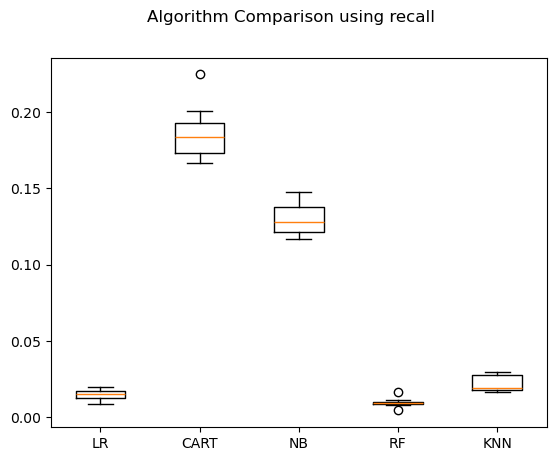

In [84]:
compare_models(n_splits, random_state, X_train, y_train)